## **Preparing Dataset for Classification**

In [16]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.lines import Line2D


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Added for Assignment
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from nltk.cluster.util import cosine_distance
from sklearn import preprocessing
import os
from xgboost import XGBClassifier



In [17]:
# Functions

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
# Showing Incorrect Classification
def plot_comp_test_data(X_test, y_test, y_head, title):
    plt.figure(figsize=(12,6))
    plt.scatter(X_test[:,0], X_test[:,6], c=[colors[i] for i in y_head], marker="*", s=60)
    n = np.size(y_head)
    for i in range(0, n):
        if y_head[i] != y_test[i]:
            plt.scatter(X_test[i,0], X_test[i,6], c=[colors[y_test[i]]], marker="X", s=120, alpha=.4)
    legend_elements = [Line2D([0], [0], marker='*', color='w', label='Prediction', markerfacecolor='k', markersize=14),
                       Line2D([0], [0], marker='X', color='w', label='Correct Class', markerfacecolor='k', markersize=12)]
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()

In [18]:
# Defining dataset and browsing content
import pandas as pd

# Download the dataset directly
url = "https://archive.ics.uci.edu/static/public/109/data.csv"
data = pd.read_csv(url)

# Display dataset info
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
 13  class

In [19]:
# Show first 10 sample
data.tail(10)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
168,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.660000,0.74,1.80,750,3
169,13.40,4.60,2.86,25.0,112,1.98,0.96,0.27,1.11,8.500000,0.67,1.92,630,3
170,12.20,3.03,2.32,19.0,96,1.25,0.49,0.40,0.73,5.500000,0.66,1.83,510,3
171,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470,3
172,14.16,2.51,2.48,20.0,91,1.68,0.70,0.44,1.24,9.700000,0.62,1.71,660,3
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.700000,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.300000,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.200000,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.300000,0.60,1.62,840,3
177,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.200000,0.61,1.60,560,3


In [20]:

import numpy as np

# Split data: X (features) and y (target)
X = np.array(data.drop(['class'], axis=1))  # 'class' is the target column
y = np.array(data['class'])

# Check the shape of y
np.shape(y)


(178,)

C:\Users\ianka\AppData\Local\Temp\ipykernel_15240\371675195.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


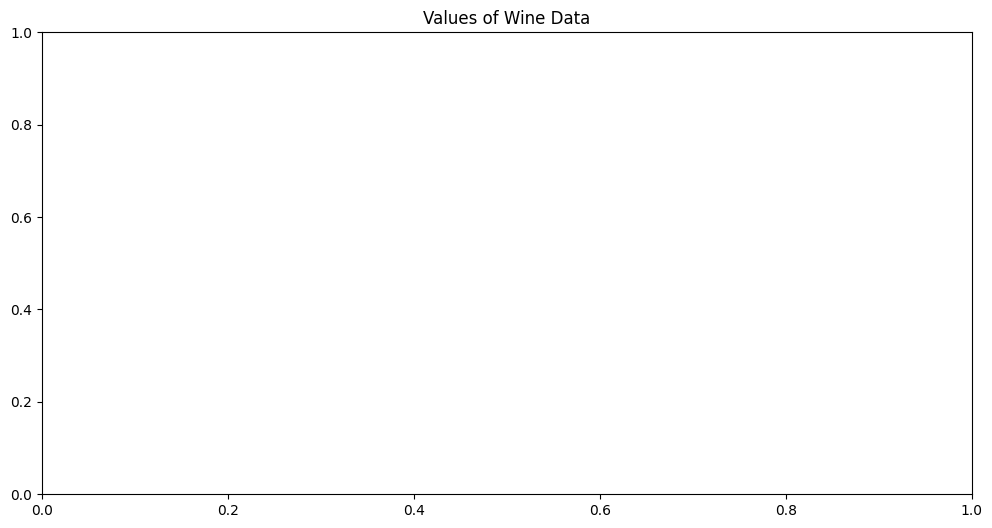

In [21]:
# Visualization Data
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig)
colors = {1:"r", 2:"g", 3:"b"}
ax.scatter(X[:,0], X[:,6], c=[colors[i] for i in y])
ax.set_xlabel("Alcohol")
ax.set_ylabel("Flavanoids")
plt.title("Values of Wine Data")
ax.legend()
plt.show()

In [22]:
# scaling each feature to a 0 to 1
X = minmax_scale(X)

In [23]:
# Create Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (133, 13)
y_train (133,)
X_test (45, 13)
y_test (45,)


Text(0, 0.5, 'Average Silhouette Score')

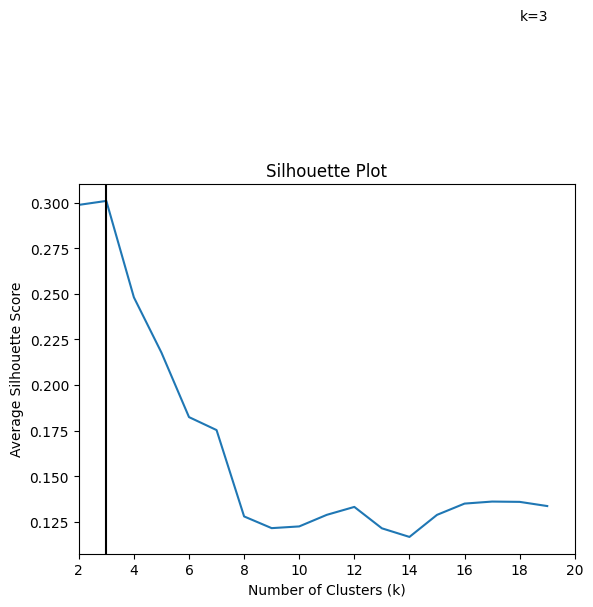

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_scores = [] # Initialize empty list to store silhouette scores

# Loop over different values of k and calculate the average silhouette score
for i in range(2, 20):
    
    # Initialize clustering with k = i
    kmeansI = KMeans(n_clusters=i, random_state=817910)
    
    # Apply clustering
    kmeansI.fit(X)
    
    # Calculate the silhouette score when k = i
    labelsI = kmeansI.fit_predict(X)
    scoreI = silhouette_score(X, labelsI)
    
    # Add silhouette score at k = i to silhouette_scores
    silhouette_scores.append((i, scoreI))
    
# Plot the average silhouette score for each value of k
x1,y1 = zip(*silhouette_scores)
plt.plot(x1, y1)

# Plot a vertical line at whichever k maximizes the silhouette score
maxK = x1[y1.index(max(y1))]
plt.axvline(x=maxK, color="black")
plt.text(18, 0.4, 'k='+str(maxK), color='black')

# Label the chart and the x and y axes
plt.title("Silhouette Plot")
plt.xlabel("Number of Clusters (k)")
plt.xlim([2,20])
plt.ylabel("Average Silhouette Score")

## **k-Nearest Neighbors (k-NN) Classification**

In [25]:
# Create k-NN classification model with GridSearchCV
# n_neighbors: Number of neighbors to use
# weights: weights is used for distance function (uniform: All points in each neighborhood are weighted equally ||
#                                                 distance: Weight points by the inverse of their distance.)
# p: Power parameter for calculate distance. (1: Manhattan Distance. 2: Eucledian Distance. 3 and upper: Minkowski Distance.)
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create k-NN hyperparameter grid
knn_grid = {"n_neighbors": np.arange(1, 15), "weights": ["uniform", "distance"], "p": [1, 2, 3]}

# Initialize the k-NN model with GridSearchCV
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=10)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("k-NN Tuned Hyperparameters:", knn.best_params_)
print("k-NN Tuned Best Score:", round(knn.best_score_, 3))

# Optionally, evaluate the performance on the test set
test_score = knn.score(X_test, y_test)
print("Test Score:", round(test_score, 3))


k-NN Tuned Hyperparameters: {'n_neighbors': np.int64(9), 'p': 1, 'weights': 'uniform'}
k-NN Tuned Best Score: 0.986
Test Score: 0.972


In [26]:
# Use best classification model
best_clf_knn = knn.best_estimator_
best_clf_knn.fit(X_train, y_train)
knn_y_head = best_clf_knn.predict(X_test)
print("k-Nearest Neighbors (k-NN) Classification Accuracy: {}%" .format(round(best_clf_knn.score(X_test, y_test)*100,2)))

k-Nearest Neighbors (k-NN) Classification Accuracy: 97.22%


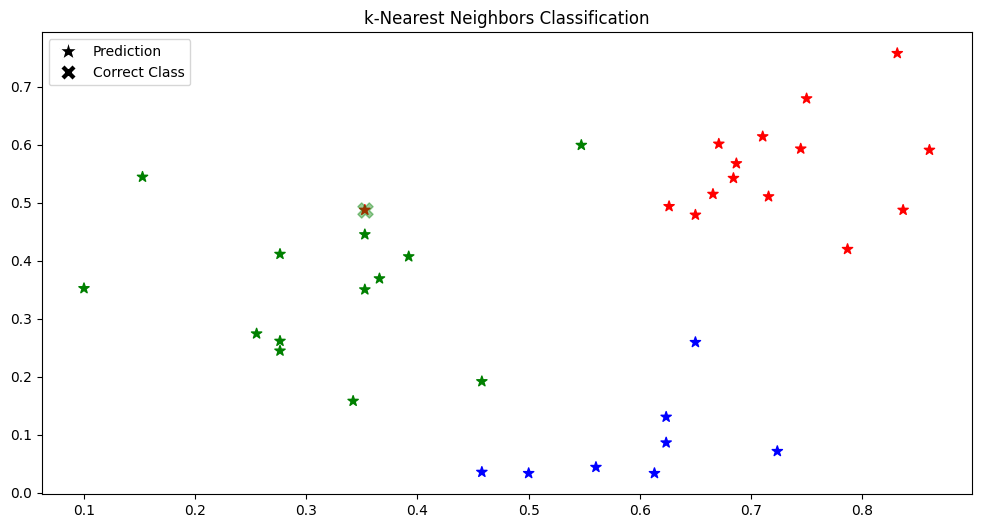

In [27]:
# Show Incorrect Classification
plot_comp_test_data(X_test, y_test, knn_y_head,title="k-Nearest Neighbors Classification")

C:\Users\ianka\AppData\Local\Temp\ipykernel_15240\290783485.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


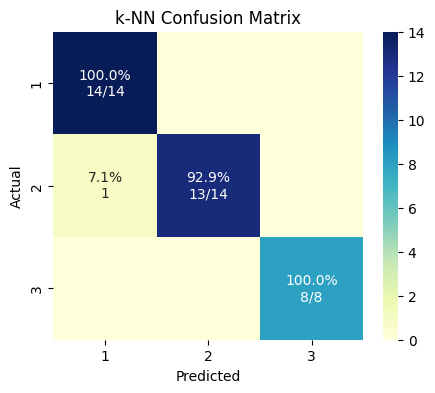

In [28]:
# Show Confusion Matrix
plot_cm(y_test, knn_y_head, title="k-NN Confusion Matrix")

**KNN CV example code here**

In [29]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Accuracy: 0.965 (0.024)


In [30]:
scores

array([0.97222222, 0.97222222, 0.94444444, 0.97142857, 0.97142857,
       0.97222222, 0.91666667, 0.97222222, 1.        , 0.94285714,
       0.97222222, 0.91666667, 0.97222222, 1.        , 0.97142857])

**Hw Part 1 - Using knn cross valididated example, add  CV analysis to DT and random Forest**

## ** Decision Tree (DT) Classification**

In [31]:
# Create DT classification model with GridSearchCV
# criterion: The function to measure the quality of a split. (Gini: Gini impurity. || Entropy: Information gain)
# min_samples_split: The minimum number of samples required to split an internal node.
# min_samples_leaf: The minimum number of samples required to be at a leaf node.
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameter grid for DecisionTreeClassifier
dtree_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Initialize GridSearchCV for Decision Tree
dtree = GridSearchCV(DecisionTreeClassifier(random_state=42), dtree_grid, cv=10)

# Fit the model on training data
dtree.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("DT Tuned Hyperparameters:", dtree.best_params_)
print("DT Tuned Best Score:", round(dtree.best_score_, 3))


DT Tuned Hyperparameters: {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 3}
DT Tuned Best Score: 0.915


In [32]:
# Use best classification model
best_clf_dt = dtree.best_estimator_
best_clf_dt.fit(X_train, y_train)
dtree_y_head = best_clf_dt.predict(X_test)
print("Decision Tree (DT) Classification Accuracy: {}%" .format(round(best_clf_dt.score(X_test, y_test)*100,2)))

Decision Tree (DT) Classification Accuracy: 94.44%


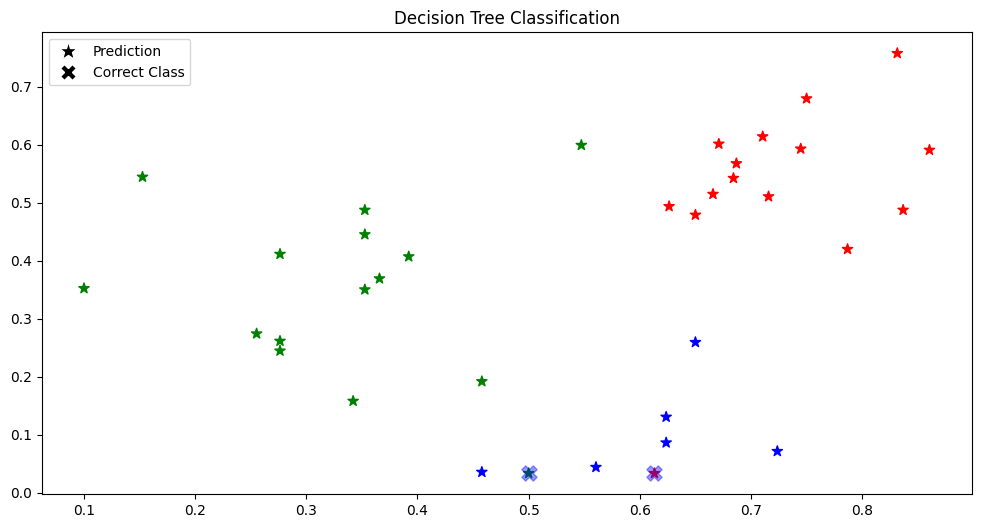

In [33]:
# Show Incorrect Classification
plot_comp_test_data(X_test, y_test, dtree_y_head, title="Decision Tree Classification")

C:\Users\ianka\AppData\Local\Temp\ipykernel_15240\290783485.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


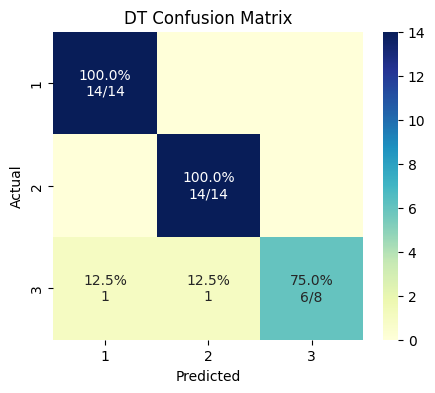

In [34]:
# Show Confusion Matrix 
plot_cm(y_test, dtree_y_head, title="DT Confusion Matrix")

**DT CV Analysis Here**

In [35]:
scores_dt = cross_val_score(dtree, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_dt), np.std(scores_dt)))

Accuracy: 0.918 (0.049)


In [36]:
scores_dt

array([0.94444444, 0.94444444, 0.91666667, 0.91428571, 0.88571429,
       0.91666667, 0.80555556, 0.94444444, 0.94285714, 0.97142857,
       0.94444444, 0.80555556, 0.94444444, 0.97142857, 0.91428571])

## ** Random Forest (RF) Classification**

In [40]:
# Create RF classification model with GridSearchCV
# n_estimators: The number of trees in the forest.
# criterion, min_samples_split and min_samples_leaf are same to decision tree parameters.
rf_grid = {
    "n_estimators": [50, 100, 150],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Create GridSearchCV without the iid parameter
rforest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_grid,
    cv=10,
    n_jobs=-1  
)

rforest.fit(X_train, y_train)

print("RF Tuned Hyperparameters:", rforest.best_params_)
print("RF Tuned Best Score:", round(rforest.best_score_, 3))

RF Tuned Hyperparameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 50}
RF Tuned Best Score: 0.979


In [41]:
best_clf_rforest = rforest.best_estimator_
best_clf_rforest.fit(X_train, y_train)
rforest_y_head = best_clf_rforest.predict(X_test)
print("Random Forest (RF) Classification Accuracy: {}%" .format(round(best_clf_rforest.score(X_test, y_test)*100,2)))

Random Forest (RF) Classification Accuracy: 100.0%


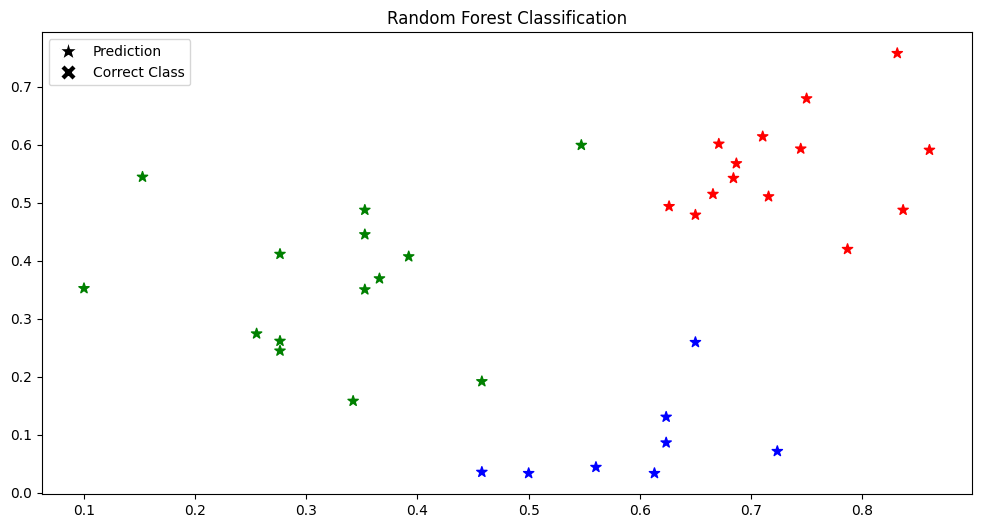

In [42]:
#Show Incorrect Classification
plot_comp_test_data(X_test, y_test, rforest_y_head, title="Random Forest Classification")

C:\Users\ianka\AppData\Local\Temp\ipykernel_15240\290783485.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


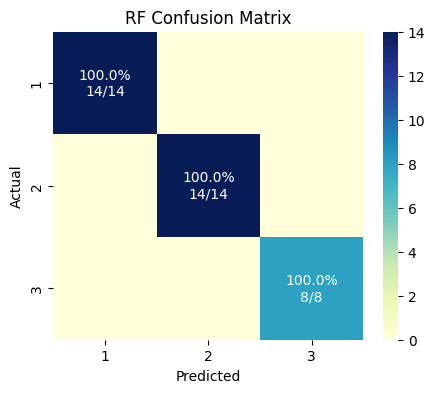

In [43]:
# Show Confusion Matrix
plot_cm(y_test, rforest_y_head, title="RF Confusion Matrix")

 *RF CV Analysis here*

In [47]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. Simplify the Random Forest (for speed)
rforest = RandomForestClassifier(
    n_estimators=50,      # Fewer trees
    max_depth=10,         # Shallower trees
    n_jobs=2,            # Use 2 cores
    random_state=42
)

# 2. Run cross-validation WITHOUT caching
scores_rf = cross_val_score(rforest, X, y, scoring='accuracy', cv=5)

print(f'Accuracy: {np.mean(scores_rf):.3f} (±{np.std(scores_rf):.3f})')

Accuracy: 0.961 (±0.022)


In [48]:
scores_rf

array([0.94444444, 0.94444444, 0.94444444, 0.97142857, 1.        ])

How do they compare using CV vs simple train/test split?

Two disadvantages of simple train/test split:
1.The selection of final model and parameters will largely depend on how you divide the training set and test set
2.This method only uses part of the data to train the model. The larger the amount of data used for model training, the better the effect of the trained model. The division of train set and test set means that we can't make full use of the data we have, so the model effect will be affected to some extent.

CV,for example, K-fold Cross Validation.
In k-fold cross-validation, the original sample is randomly partitioned into k equal sized groups. From the k groups, one group would be removed as a hold-out set and the remaining groups would be the training data. The predictive model is then fit on the training data and evaluated on the hold-out set. This procedure is k times so that all groups have served exactly once as the hold-out set.


**Part 2 - Add your chosen model code here - don't forget to do CV analysis**

For this ignore grid search step in the code above and just take your chosen models defaults

## ** Xgboost (XGB) Classification**

In [50]:
import numpy as np
from xgboost import XGBClassifier

# 1. Convert classes to 0-based indexing
y_train_remapped = np.array(y_train) - 1  # Turns [1,2,3] → [0,1,2]

# 2. Verify the new classes
print("Unique classes in y_train:", np.unique(y_train))
print("Remapped classes:", np.unique(y_train_remapped))  # Should show [0 1 2]

# 3. Train XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train_remapped)

Unique classes in y_train: [1 2 3]
Remapped classes: [0 1 2]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [51]:
# make predictions for test data
xgb_y_head = xgb.predict(X_test)
print("Xgboost (xgb) Classification Accuracy: {}%" .format(round(xgb.score(X_test, y_test)*100,2)))

Xgboost (xgb) Classification Accuracy: 2.78%


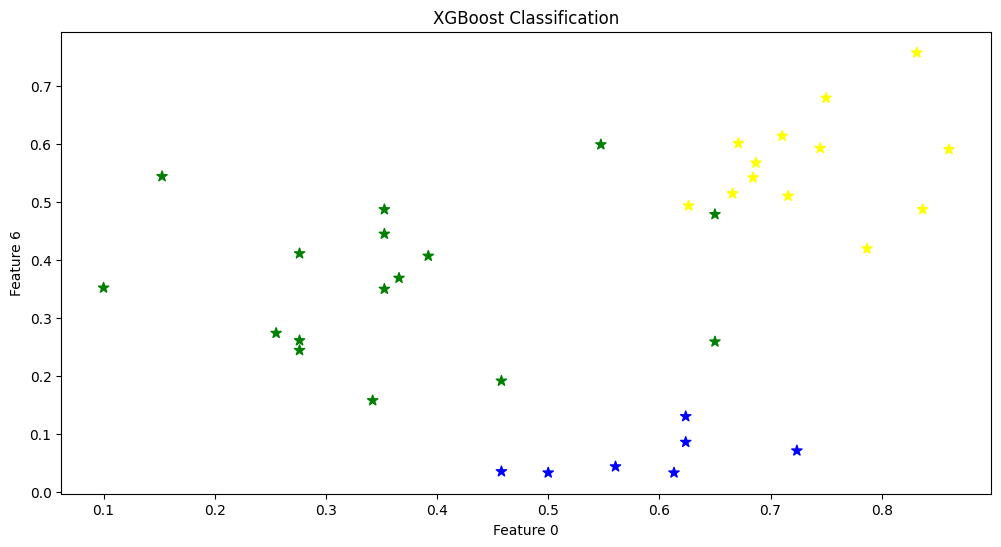

In [53]:
import matplotlib.pyplot as plt

# 1. Define colors for ALL classes (including 0)
colors = {
    0: 'yellow',  # New color for class 0 (originally class 1)
    1: 'green',   # Class 1 (originally class 2)
    2: 'blue'     # Class 2 (originally class 3)
}

# 2. Modified plotting function
def plot_comp_test_data(X_test, y_test, y_head, title):
    plt.figure(figsize=(12,6))
    
    # Convert to numpy array if using pandas
    if hasattr(X_test, 'iloc'):
        x1 = X_test.iloc[:,0].values
        x2 = X_test.iloc[:,6].values
    else:
        x1 = X_test[:,0]
        x2 = X_test[:,6]
    
    plt.scatter(x1, x2, c=[colors[i] for i in y_head], marker="*", s=60)
    plt.title(title)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 6")
    plt.show()

# 3. Call with remapped predictions
plot_comp_test_data(X_test, y_test, xgb_y_head, title="XGBoost Classification")

C:\Users\ianka\AppData\Local\Temp\ipykernel_15240\290783485.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


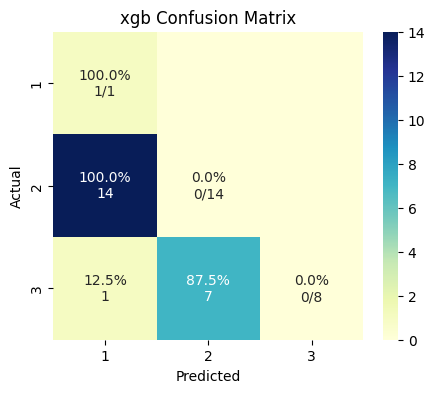

In [54]:
# Show Confusion Matrix
plot_cm(y_test, xgb_y_head, title="xgb Confusion Matrix")

**XGB CV Analysis Here**

In [56]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# 1. Convert classes to 0-based
y_remapped = np.array(y) - 1  # [1,2,3] → [0,1,2]

# 2. Initialize XGBoost with correct num_class
xgb = XGBClassifier(
    n_estimators=100,
    num_class=len(np.unique(y_remapped)),  # Important for multiclass
    n_jobs=-1
)

# 3. Run cross-validation
scores_xgb = cross_val_score(xgb, X, y_remapped, 
                           scoring='accuracy', 
                           cv=5,  # Reduced from cv=15 for speed
                           n_jobs=2)  # Limit parallel jobs

print(f'Accuracy: {np.mean(scores_xgb):.3f} (±{np.std(scores_xgb):.3f})')

Accuracy: 0.950 (±0.032)


In [57]:
scores_xgb

array([0.94444444, 0.91666667, 0.91666667, 0.97142857, 1.        ])